# Before running the program ensure that:
#### 1. Download the latest Analytical Report
#### 2. Update strategies from BEX
#### 3. Adjust dates in Analytical Report
#### 4. Download Actuals Report
#### 5. Run Actuals for the desired book
#### 6. Define RADAR REPORT (CRUDE, HEAVY, MD, LIGHT)
#### 7. Define Dates
#### 8. Define Export files

# Define RADAR REPORT and DATES

In [2]:
import numpy as np
import pandas as pd
import datetime

import warnings
warnings.filterwarnings("ignore")

In [3]:
# defining Radar Report

radar_report = 'CRUDE'


# define radar date

radar_date = '2017-10-27'
end_date = '2017-11-30'
add_days = pd.to_datetime(end_date) - pd.to_datetime(radar_date)
#add_days = 59
add_days = int(str(add_days)[:2])
add_days

34

# Import Python libraries and Analytical Report

In [4]:
df = pd.read_excel('0FLATANALYTICALexport.XLSX')

# the Due date (+), TTD (-) and TTD (+) need to be datetime64
#df.dtypes

# Counterparties and dates

In [5]:
# correction of counterparty (+)
df['Counterparty (+)'] = np.where((df['Mirror portfolio name (+)'].isnull() == True ),
                                  df['Counterparty (+)'],
                                  np.where(df['Mirror Line of Business (+)'] == df['Line of Business'],
                                          df['Mirror Line of Business (+)'].str[:3] + ' ' + df['Mirror portfolio name (+)'],
                                          df['Mirror Line of Business (+)'] + ' ' + df['Mirror portfolio name (+)']))

In [6]:
# correction of counterparty (-)
df['Counterparty (-)'] = np.where((df['Mirror portfolio name (-)'].isnull() == True ),
                                  df['Counterparty (-)'],
                                 np.where(df['Mirror Line of Business (-)'] == df['Line of Business'],
                                         df['Mirror Line of Business (-)'].str[:3] + ' '+ df['Mirror portfolio name (-)'],
                                          df['Mirror Line of Business (-)'] + ' ' + df['Mirror portfolio name (-)']))

In [7]:
#correction of Due date (-)
df['Due date (-)'] = df['Due date (-)'].astype('datetime64[ns]')
df['Due date (-)'][df['Due date (-)'] == '1816-03-29 05:56:08.066277376' ] = 0
df['test'] = np.where(df['Due date (-)'] == '1970-01-01', 0, 1)

# correction of Title transfer date (-)
df['Title transfer date (-)'] = df['Title transfer date (-)'].astype(object).where(df['Title transfer date (-)'].notnull(), 0)
df['Title transfer date (-)'] = np.where(df['Title transfer date (-)'] == 0, pd.to_datetime('today') + np.timedelta64(30,'D') , df['Title transfer date (-)'])
df['Title transfer date (-)'] = df['Title transfer date (-)'].astype('datetime64[ns]')

#continuation of correction of Due date (-)
df['Due date (-) corrected'] = np.where(df['test'] == 1, df['Due date (-)'], df['Due date (+)'] - df['Title transfer date (+)'] + df['Title transfer date (-)'])

df['Due date (-)'] = df['Due date (-) corrected']

# converting the type of Due date (-)
df['Due date (-)'] = df['Due date (-)'].astype('datetime64[ns]')
df['Due date (-)'] = df['Due date (-)'].dt.date

df['Consumption Date'] = df['Due date (+)']
df['Due date (+)'] = df['Due date (+)'].dt.date
df['Title transfer date (-)'] = df['Title transfer date (-)'].dt.date
df['Title transfer date (+)'] = df['Title transfer date (+)'].dt.date


#filling NaN
df['Incoterms 1 (-)'].fillna(df['Incoterms 1 (+)'], inplace=True)
df['Incoterms 2 country (-)'].fillna(df['Incoterms 2 country (+).1'], inplace=True)
df['Incoterms 2 country (-).1'].fillna(df['Incoterms 2 country (+)'], inplace=True)


# Days operations

In [8]:
# calculating the columns

df['Consumption Type'] = 'Filled by Macros'
df['Total WC Consumption period'] = df['Due date (-)'] - df['Due date (+)']
df['TTD difference'] = df['Title transfer date (-)'] - df['Title transfer date (+)']
df['Sale Payment Terms'] = df['Due date (-)'] - df['Title transfer date (-)']
df['Buy Payment Terms'] = df['Due date (+)'] - df['Title transfer date (+)']
df['PDD difference'] = df['Sale Payment Terms'] - df['Buy Payment Terms']
df['Consumption reason'] = 'OTHER'
df['WC Amount'] = df['WC consumption amount'] / 1000000
df['Current amount in USD (+)'] = df['Quantity BBL (ratio) (+)'] * df['Current price, USD/BBL (+)']
df['Current amount in USD (-)'] = df['Quantity BBL (ratio) (-)'] * df['Current price, USD/BBL (-)']

# company name
df['Company Name'] = df['Line of Business'].str[:3]

# portfolio name
df['Portfolio name change'] = df['Company Name'] + ' ' + df['Portfolio name']
df['Portfolio name'] = df['Portfolio name change']


# converting columns to the right format
#converting into days
df['Total WC Consumption period'] = df['Total WC Consumption period'].dt.days
df['TTD difference'] = df['TTD difference'].dt.days
df['Sale Payment Terms'] = df['Sale Payment Terms'].dt.days
df['Buy Payment Terms'] = df['Buy Payment Terms'].dt.days
df['PDD difference'] = df['PDD difference'].dt.days

# WC Amount

In [9]:
# correcting the WC Amount
df_strategy = pd.DataFrame()
df_strategy = df[['Strategy', 'WC Amount','Strategy start date']].copy()

#import the strategies
df_strategy_exclude = pd.read_excel('Strategies.xlsx')

#conditions and sum
df_strategy = df_strategy.merge(df_strategy_exclude, on = 'Strategy', how = 'left')
df_strategy['New'].fillna(0, inplace=True)
df_strategy['S2'] = np.where(df_strategy['Strategy'] > 517000, 1,0)
df_strategy['ssd'] = np.where(df_strategy['Strategy start date'] > '2015-12-01', 1,0)
df_strategy['sum_s'] = df_strategy['New'] + df_strategy['ssd'] + df_strategy['S2']
df_strategy['WC Amount corrected'] = np.where(df_strategy['sum_s'] > 0,df_strategy['WC Amount'], 0)

# replacing WC amount
df['WC Amount'] = df_strategy['WC Amount corrected']

# rounding WC amount and filter
df['WC Amount'] = df['WC Amount'].round(4)
df = df[(df['WC Amount'] <= -0.50) | (df['WC Amount'] >= 0.50) ]

# reset index
df = df.reset_index(drop=True)

# WC Days: Total, TTD and PDD

In [10]:
def f(row):
    if (row['Total WC Consumption period'] >= row['TTD difference'] and row['Total WC Consumption period'] > 0 and row['TTD difference'] > 0) \
    or (row['Total WC Consumption period'] <= row['TTD difference'] and row['Total WC Consumption period'] < 0 and row['TTD difference'] < 0):
        return row['TTD difference']
    elif (row['Total WC Consumption period'] > 0 and row['TTD difference'] > 0) \
    or (row['Total WC Consumption period'] < 0 and row['TTD difference'] < 0):
        return row['Total WC Consumption period']
    else:
        return 0

In [11]:
df['TTD influence on WC consumption'] = df.apply(f, axis=1)
df['PDD influence on WC consumption'] = df['Total WC Consumption period'] - df['TTD influence on WC consumption']

# Select columns

In [12]:
# rearrange columns
cols = df.columns.tolist()

In [13]:
cols = ['Consumption Date',
       'Consumption Type',
       'Total WC Consumption period',
        'TTD influence on WC consumption',
        'PDD influence on WC consumption',
        'TTD difference',
        'PDD difference',
        'Sale Payment Terms',
        'Buy Payment Terms',
        'Consumption reason',
        'WC Amount',
        'Buy/Sell (-)',
        'Buy/Sell (+)',
        'Due date (-)',
        'Due date (+)',
        'Title transfer date (-)',
        'Title transfer date (+)',
        'Strategy',
        'Strategy name',
        'Company Name',
        'Global Book name',
        'Line of Business',
        'Book Name',
        'Portfolio name',
        'Quantity',
        'Current amount in USD (+)',
        'Quantity BBL (ratio) (+)',
        'Current price, USD/BBL (+)',
        'Counterparty (+)',
        'Title transfer (+)',
        'Incoterms 1 (+)',
        'Incoterms 2 country (+)',
        'Incoterms 2 country (+).1',
        'Object type (+)',
        'Delivery ID (+)',
        'Internal type (+)',
        'Mirror Delivery ID (+)',
        'Current amount in USD (-)',
        'Quantity BBL (ratio) (-)',
        'Current price, USD/BBL (-)',
        'Counterparty (-)',
        'Title transfer (-)',
        'Incoterms 1 (-)',
        'Incoterms 2 country (-)',
        'Incoterms 2 country (-).1',
        'Object type (-)',
        'Delivery ID (-)',
        'Internal type (-)',
        'Mirror Delivery ID (-)',
        'Strategy start date',
        'Strategy end date',
        'Voyage ID (+)',
        'Transport name (+)',
        'Grade (+)',
        'Voyage ID (-)',
        'Transport name (-)',
        'Grade (-)']

In [14]:
# ordering the columns
df = df[cols]
df.shape

(6918, 57)

# Filter data

In [15]:
# selecting rows for which dates are above -365 or below 365
df = df[(df['Total WC Consumption period'] > -365) & (df['Total WC Consumption period'] < 365) ]

# reset index
df = df.reset_index(drop=True)
df.shape

(6909, 57)

# Stock in Transit and Payment Terms

In [16]:
# stock in transit
stock_in_transit = df.loc[df.index.repeat(abs(df['TTD influence on WC consumption']))]
stock_in_transit['Consumption Date'] = stock_in_transit['Consumption Date'] + pd.to_timedelta(abs(stock_in_transit['TTD influence on WC consumption'])-1, 'D')

stock_in_transit.loc[:,'Consumption Date'] -= pd.to_timedelta(stock_in_transit.groupby(level=0).cumcount(),'D')
stock_in_transit = stock_in_transit.reset_index(drop=True)
stock_in_transit['Consumption Type'] = 'Stock in Transit'
stock_in_transit = stock_in_transit[(stock_in_transit['Consumption Date'] > '2016-12-31')]

# correct the negatives
stock_in_transit['Consumption Date'] = np.where(stock_in_transit['TTD influence on WC consumption'] < 0,
                                                stock_in_transit['Consumption Date'] +
                                                pd.to_timedelta(stock_in_transit['TTD influence on WC consumption'], 'D'),
                                                stock_in_transit['Consumption Date'])

#filter date
stock_in_transit = stock_in_transit[(stock_in_transit['Consumption Date'] > '2016-12-31')]
stock_in_transit = stock_in_transit.reset_index(drop=True)

stock_in_transit.shape

(33203, 57)

In [17]:
# payment terms
payment_terms = df.loc[df.index.repeat(abs(df['PDD influence on WC consumption']))]
payment_terms['Consumption Date'] = np.where(payment_terms['PDD influence on WC consumption'] >= 0,
                                                payment_terms['Consumption Date'] +
                                                pd.to_timedelta(abs(payment_terms['Total WC Consumption period']) -1, 'D'),
                                                payment_terms['Consumption Date'] - pd.to_timedelta(1, 'D') +
                                            pd.to_timedelta(payment_terms['TTD influence on WC consumption'], 'D'))

payment_terms.loc[:,'Consumption Date'] -= pd.to_timedelta(payment_terms.groupby(level=0).cumcount(),'D')
payment_terms = payment_terms.reset_index(drop=True)
payment_terms['Consumption Type'] = 'Payment Terms'

# filter date
payment_terms = payment_terms[(payment_terms['Consumption Date'] > '2016-12-31')]
payment_terms = payment_terms.reset_index(drop=True)

payment_terms.shape

(24191, 57)

# Tableau data

In [18]:
df_output = pd.concat([stock_in_transit, payment_terms])
df_output = df_output.reset_index(drop=True)
df_output.shape

(57394, 57)

# Selection for others

In [19]:
df_agg = df_output.groupby(['Consumption Date', 'Strategy']).sum().reset_index()
df_agg = df_agg[['Consumption Date', 'Strategy', 'WC Amount']]
df_agg['WC Amount'] = df_agg['WC Amount']*-1

#filter the date
df_agg = df_agg[(df_agg['Consumption Date'] <= radar_date)]


# Import Actuals

In [20]:
act = pd.read_excel('1ALLBOOKWCActuals - ETRM.xlsm', sheetname= radar_report, header=None,
                          names = ["Company Code", "Consumption Date", "Strategy", "WC Amount"])

#selecting cols
act = act[['Consumption Date', 'Strategy', 'WC Amount']]
act['WC Amount'] = act['WC Amount']/1000000

# Joining Analytical and Actuals --> Other

In [21]:
# joining the two dataframes

df_others = pd.concat([df_agg, act])
df_others.shape

(537125, 3)

In [22]:
# groupby and exclude the small amounts

df_others = df_others.groupby(['Consumption Date', 'Strategy']).sum().reset_index()
df_others = df_others[(df_others['WC Amount'] > 0.1) | (df_others['WC Amount'] < -0.1) ]
df_others = df_others.reset_index(drop=True)
df_others.shape

(75910, 3)

In [23]:
# only the radar date and defining days_count

df_others_radar_date = df_others[(df_others['Consumption Date'] == radar_date)]
df_others_radar_date = df_others_radar_date.reset_index(drop=True)
days_count = df_others_radar_date.shape[0]

In [24]:
print(days_count)
print(radar_date)
print(add_days)
print(end_date)

253
2017-10-27
34
2017-11-30


In [25]:
# replicating the data until the last day of radar report

df_others_replication = pd.concat([df_others_radar_date]*add_days)
df_others_replication = df_others_replication.reset_index(drop=True)
df_others_replication.shape

(8602, 3)

In [26]:
# changing the dates: from radar date + 1 day until last day of next month

for x in xrange(0,add_days):
    df_others_replication.iloc[x*days_count:days_count*(x+1)]['Consumption Date'] = df_others_replication.iloc[x*days_count:days_count*(x+1)]['Consumption Date'] + pd.to_timedelta(x+1,'D')

In [27]:
df_others = pd.concat([df_others, df_others_replication])

# Joining Others to Tableau data

In [28]:
df_others['Consumption Type'] = np.where (df_others['Strategy'].str.contains('MARGIN') == True, 'Margin Call',
                                          np.where(df_others['Strategy'].str.contains('UNASSIGNED') == True, 'Other Unassigned',
                                                   'Other'))
df_others = df_others.reset_index(drop=True)

In [29]:
# this gives all strategies available in the analytical report
output_strategy = df_output[['Strategy', 'Strategy name', 'Global Book name', 'Line of Business','Book Name', 'Portfolio name' ]]
output_strategy = output_strategy.drop_duplicates()
output_strategy = output_strategy.reset_index(drop=True)

In [30]:
# this gives all strategies from ETRM (file needs to be updated before running the script)
all_strategies = pd.read_excel('all_strategy.xlsx')
all_strategies = all_strategies[['Strategy', 'Strategy name','Global Book name', 'Line of Business','Book Name', 'Portfolio name' ]]
all_strategies['Portfolio name update'] = all_strategies['Line of Business'].str[:3] + ' ' + all_strategies['Portfolio name']
all_strategies['Portfolio name'] = all_strategies['Portfolio name update']
all_strategies = all_strategies[['Strategy', 'Strategy name','Global Book name', 'Line of Business','Book Name', 'Portfolio name' ]]

In [31]:
df_others = df_others.merge(output_strategy, on='Strategy', how='left')

In [32]:
df_others2 = all_strategies[['Strategy', 'Strategy name']]

In [33]:
df_others3 = df_others.merge(all_strategies, on='Strategy',how='left')

In [34]:
df_others3['Strategy name'] = np.where(df_others3['Strategy name_x'].isnull() == True,
                                          df_others3['Strategy name_y'], df_others3['Strategy name_x'])

df_others3['Global Book name'] = np.where(df_others3['Global Book name_x'].isnull() == True,
                                          df_others3['Global Book name_y'], df_others3['Global Book name_x'])

df_others3['Line of Business'] = np.where(df_others3['Line of Business_x'].isnull() == True,
                                          df_others3['Line of Business_y'], df_others3['Line of Business_x'])

df_others3['Book Name'] = np.where(df_others3['Book Name_x'].isnull() == True,
                                          df_others3['Book Name_y'], df_others3['Book Name_x'])

df_others3['Portfolio name'] = np.where(df_others3['Portfolio name_x'].isnull() == True,
                                          df_others3['Portfolio name_y'], df_others3['Portfolio name_x'])

In [35]:
# adding company name and updating portfolio name
df_others3 = df_others3.fillna('Unknown')
df_others3['Company Name'] = np.where(df_others3['Line of Business'] == 'Unknown', df_others3['Strategy'].str[:3], 
                                    df_others3['Line of Business'].str[:3])
df_others3['Portfolio name'] = np.where(df_others3['Portfolio name'] == 'Unknown', df_others3['Strategy'], df_others3['Portfolio name'])

In [36]:
#selecting the cols

df_others4 = df_others3[['Consumption Date', 'Strategy','WC Amount', 'Consumption Type', 'Strategy name','Company Name',
                    'Global Book name','Line of Business','Book Name', 'Portfolio name']]

# joining others to tableau output

In [37]:
result_others = pd.DataFrame(columns=cols)
result_others['Consumption Date'] = df_others4['Consumption Date']
result_others['Consumption Type'] = df_others4['Consumption Type']
result_others['WC Amount'] = df_others4['WC Amount']
result_others['Strategy'] = df_others4['Strategy']
result_others['Strategy name'] = df_others4['Strategy name']
result_others['Company Name'] = df_others4['Company Name']
result_others['Global Book name'] = df_others4['Global Book name']
result_others['Line of Business'] = df_others4['Line of Business']
result_others['Book Name'] = df_others4['Book Name']
result_others['Portfolio name'] = df_others4['Portfolio name']

In [38]:
df_final = pd.concat([df_output,result_others]).reset_index(drop=True)

# Export 1

In [39]:
# before macros
#writer = pd.ExcelWriter('before macros.xlsx')
#df.to_excel(writer, 'data')
#writer.save()

In [40]:
# stock in transit
#writer = pd.ExcelWriter('stock_in_transit.xlsx')
#stock_in_transit.to_excel(writer, 'data')
#writer.save()

In [41]:
# payment terms
#writer = pd.ExcelWriter('payment_terms.xlsx')
#payment_terms.to_excel(writer, 'data')
#writer.save()

In [42]:
# tableau data
#writer = pd.ExcelWriter('tableau data.xlsx')
#df_output.to_excel(writer, 'Tableau')
#writer.save()

In [43]:
# others
#writer = pd.ExcelWriter('others.xlsx')
#df_others.to_excel(writer, 'data')
#writer.save()

In [44]:
# others with description
#writer = pd.ExcelWriter('others desc.xlsx')
#df_others4.to_excel(writer, 'data')
#writer.save()

In [45]:
# final output
#writer = pd.ExcelWriter('final output.xlsx')
#df_final.to_excel(writer, 'data')
#writer.save()

# Gross Working Capital in the Radar Report Date

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
#creating data sets for the plot

df_type = df_final.groupby(['Consumption Date', 'Consumption Type'])['WC Amount'].sum().reset_index()

#stock in transit for plot
df_transit = df_type[(df_type['Consumption Type'] == 'Stock in Transit')]

#payment terms for plot
df_terms = df_type[(df_type['Consumption Type'] == 'Payment Terms')]

#other for plot
df_plot_others = df_type[(df_type['Consumption Type'] == 'Other')]

#others unassigned for plot
df_plot_others_u = df_type[(df_type['Consumption Type'] == 'Other Unassigned')]


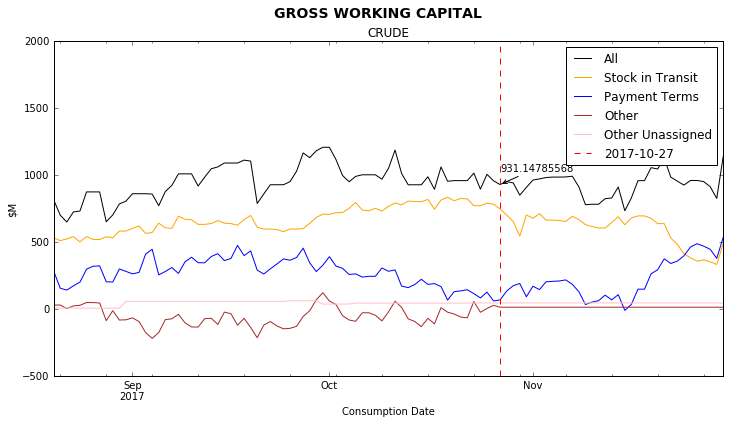

In [48]:
# group by strategies the total amount
daily_wc = df_final.groupby('Consumption Date')['WC Amount'].sum().reset_index()

# our GWC amount for the date
radar_date_wc = daily_wc.set_index('Consumption Date').loc[radar_date]['WC Amount']

# Create the figure and the axes
fig, ax = plt.subplots()

# Plot the data
daily_wc.plot(kind='line',y='WC Amount', x='Consumption Date', ax=ax, figsize=(12, 6), color= 'black', label='All')
df_transit.plot(kind='line', y='WC Amount', x='Consumption Date',ax=ax, figsize=(12,6), color='orange', label= 'Stock in Transit')
df_terms.plot(kind='line', y='WC Amount', x='Consumption Date',ax=ax, figsize=(12,6), color='blue', label='Payment Terms')
df_plot_others.plot(kind='line', y='WC Amount', x='Consumption Date',ax=ax, figsize=(12,6), color='brown', label='Other')
df_plot_others_u.plot(kind='line', y='WC Amount', x='Consumption Date',ax=ax, figsize=(12,6), color='pink',
                      label='Other Unassigned')

# Set limits and labels
ax.set_xlim(['2017-08-20', end_date])
ax.set(title=radar_report, xlabel='Consumption Date', ylabel='$M')

# Add a line for radar date
ax.axvline(x=radar_date, color='r',
           label=radar_date,
           linestyle='--',
           linewidth=1)

ax.annotate(radar_date_wc,
            xy=(radar_date, radar_date_wc), xycoords='data',
           xytext=(radar_date, radar_date_wc + 100), textcoords='data',
           arrowprops=dict(arrowstyle="->",
                          connectionstyle="arc3")
            )

# Hide the legend
ax.legend().set_visible(True)

# Title the figure
fig.suptitle('GROSS WORKING CAPITAL', fontsize=14, fontweight='bold');

# Other Gross Working Capital

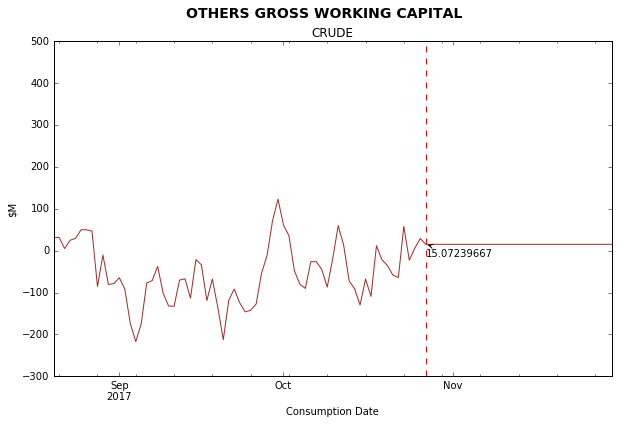

In [49]:
# we are only interested in others so we filter the final df
df_final_others = df_final[df_final['Consumption Type'] == 'Other']

#group by day
daily_wc_others = df_final_others.groupby('Consumption Date')['WC Amount'].sum().reset_index()

# value of others in radar date
radar_date_wc_other = daily_wc_others.set_index('Consumption Date').loc[radar_date]['WC Amount']

# Create the figure and the axes
fig, ax = plt.subplots()

# Plot the data
daily_wc_others.plot(kind='line',y='WC Amount', x='Consumption Date', ax=ax, figsize=(10, 6), color = 'brown')

# Set limits and labels
ax.set_xlim(['2017-08-20', end_date])
ax.set(title=radar_report, xlabel='Consumption Date', ylabel='$M')

# Add a line for radar date
ax.axvline(x=radar_date, color='r',
           label=radar_date,
           linestyle='--',
           linewidth=1)

ax.annotate(radar_date_wc_other,
            xy=(radar_date, radar_date_wc_other), xycoords='data',
           xytext=(radar_date, radar_date_wc_other - 30), textcoords='data',
           arrowprops=dict(arrowstyle="->",
                          connectionstyle="arc3")
            )

# Hide the legend
ax.legend().set_visible(False)

# Title the figure
fig.suptitle('OTHERS GROSS WORKING CAPITAL', fontsize=14, fontweight='bold');

# CRUDE ADJUSTMENTS

In [50]:
# Portfolio name containing 'Emissions' assigned to Other

df_final['Consumption Type'] = np.where(df_final['Portfolio name'].str.contains('Emissions') == True,
                                        'Other', df_final['Consumption Type'])

# HEAVY ADJUSTMENTS

In [51]:
# Prepayment to NICO

df_final['Consumption Type'] = np.where(df_final['Strategy name'].str.contains('NICO') == True,
                                        'Prepayment to NICO', df_final['Consumption Type'])

In [52]:
# East Arbitrage to Stock in Transit

df_final['Consumption Type'] = np.where((df_final['Portfolio name'] == 'GVA T-Cracked East ARB') & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])
# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Portfolio name'] == 'GVA T-Cracked East ARB') & \
    (df_final['TTD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country to SG
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Portfolio name'] == 'GVA T-Cracked East ARB') & \
    (df_final['Incoterms 2 country (-).1'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
'SG', df_final['Incoterms 2 country (-).1'])

In [55]:
# LAP to Stock in Transit

df_final['Consumption Type'] = np.where(df_final['Company Name'] == 'LAP', 'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Company Name'] == 'LAP') & (df_final['TTD influence on WC consumption'].isnull() == True),
30, df_final['TTD influence on WC consumption'])

# adjust country to SG
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Company Name'] == 'LAP') & (df_final['Incoterms 2 country (-).1'].isnull() == True),
'SG', df_final['Incoterms 2 country (-).1'])

In [56]:
# all others in GVA T-Cracked Storages to Stock in transit

df_final['Consumption Type'] = np.where(
    (df_final['Portfolio name'] == 'GVA T-Cracked Storages') & (df_final['Consumption Type'] == 'Other'),
'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Portfolio name'] == 'GVA T-Cracked Storages') & \
    (df_final['TTD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country to NL
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Portfolio name'] == 'GVA T-Cracked Storages') & \
    (df_final['Incoterms 2 country (-).1'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
'NL', df_final['Incoterms 2 country (-).1'])


# DISTILLATES

### ENERGEN I

In [109]:
# str. 512092 to Payment Terms
df_final['Consumption Type'] = np.where((df_final['Strategy'] == 512092) & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Payment Terms', df_final['Consumption Type'])

# adjust Payment Terms days 
df_final['PDD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 512092) & \
    (df_final['PDD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['PDD influence on WC consumption'])

# adjust Counterparty (+)
df_final['Counterparty (+)'] = np.where(
    (df_final['Strategy'] == 512092) & \
    (df_final['Counterparty (+)'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[512092]['Counterparty (+)'].unique()[0]),
    df_final['Counterparty (+)'])

# adjust Counterparty (-)
df_final['Counterparty (-)'] = np.where(
    (df_final['Strategy'] == 512092) &\
        (df_final['Counterparty (-)'].isnull() == True) &\
        (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[512092]['Counterparty (-)'].unique()[0]),
    df_final['Counterparty (-)'])

In [110]:
# str. 512619 to Payment Terms
df_final['Consumption Type'] = np.where((df_final['Strategy'] == 512619) & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Payment Terms', df_final['Consumption Type'])

# adjust Payment Terms days 
df_final['PDD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 512619) & \
    (df_final['PDD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['PDD influence on WC consumption'])

# adjust Counterparty (+)
df_final['Counterparty (+)'] = np.where(
    (df_final['Strategy'] == 512619) & \
    (df_final['Counterparty (+)'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[512619]['Counterparty (+)'].unique()[0]),
    df_final['Counterparty (+)'])

# adjust Counterparty (-)
df_final['Counterparty (-)'] = np.where(
    (df_final['Strategy'] == 512619) &\
        (df_final['Counterparty (-)'].isnull() == True) &\
        (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[512619]['Counterparty (-)'].unique()[0]),
    df_final['Counterparty (-)'])

### ENERGEN II

In [111]:
# str. 512277 to Stock in Transit
df_final['Consumption Type'] = np.where((df_final['Strategy'] == 512277) &\
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 512277) &\
    (df_final['TTD influence on WC consumption'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 512277) &\
    (df_final['Incoterms 2 country (-).1'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[512277]['Incoterms 2 country (-).1'].unique()[0]),
    df_final['Incoterms 2 country (-).1'])

In [112]:
# str. 512413 to Stock in Transit
df_final['Consumption Type'] = np.where((df_final['Strategy'] == 512413) &\
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 512413) &\
    (df_final['TTD influence on WC consumption'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 512413) &\
    (df_final['Incoterms 2 country (-).1'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[512413]['Incoterms 2 country (-).1'].unique()[0]),
    df_final['Incoterms 2 country (-).1'])

In [113]:
# str. 511914 to Stock in Transit
df_final['Consumption Type'] = np.where((df_final['Strategy'] == 511914) &\
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 511914) &\
    (df_final['TTD influence on WC consumption'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 511914) &\
    (df_final['Incoterms 2 country (-).1'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[511914]['Incoterms 2 country (-).1'].unique()[0]),
    df_final['Incoterms 2 country (-).1'])

In [114]:
# str. 509769 to Stock in Transit
df_final['Consumption Type'] = np.where((df_final['Strategy'] == 509769) &\
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 509769) &\
    (df_final['TTD influence on WC consumption'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 509769) &\
    (df_final['Incoterms 2 country (-).1'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[509769]['Incoterms 2 country (-).1'].unique()[0]),
    df_final['Incoterms 2 country (-).1'])

In [115]:
# str. 509874 to Stock in Transit
df_final['Consumption Type'] = np.where((df_final['Strategy'] == 509874) &\
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 509874) &\
    (df_final['TTD influence on WC consumption'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 509874) &\
    (df_final['Incoterms 2 country (-).1'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[509874]['Incoterms 2 country (-).1'].unique()[0]),
    df_final['Incoterms 2 country (-).1'])

In [116]:
# str. 509377 to Stock in Transit
df_final['Consumption Type'] = np.where((df_final['Strategy'] == 509377) &\
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 509377) &\
    (df_final['TTD influence on WC consumption'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 509377) &\
    (df_final['Incoterms 2 country (-).1'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[509377]['Incoterms 2 country (-).1'].unique()[0]),
    df_final['Incoterms 2 country (-).1'])

### ENERGEN III

In [117]:
# a portfolio containing Yemen goes to Stock in Transit. Adjust days and country

df_final['Consumption Type'] = np.where(
    (df_final['Portfolio name'].str.contains('Yemen') == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Portfolio name'].str.contains('Yemen') == True) &\
    (df_final['TTD influence on WC consumption'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 509377) &\
    (df_final['Incoterms 2 country (-).1'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[509377]['Incoterms 2 country (-).1'].unique()[0]),
    df_final['Incoterms 2 country (-).1'])


### ENERGEN IV

In [118]:
# strategy 521769 from Payment Terms to Stock in Transit

df_final['Consumption Type'] = np.where(
    (df_final['Strategy'] == 521769) & (df_final['Consumption Type'] == 'Payment Terms'),
    'Stock in Transit', df_final['Consumption Type'])

### LAP

In [119]:
# All LAP sent to Stock in Transit , except margin calls

df_final['Consumption Type'] = np.where(
    (df_final['Company Name'] == 'LAP') &\
    (df_final['Consumption Type'] != 'Margin Call'),
    'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Company Name'] == 'LAP') & \
    (df_final['TTD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call') ,
30, df_final['TTD influence on WC consumption'])

# adjust country to SG
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Company Name'] == 'LAP') & \
    (df_final['Incoterms 2 country (-).1'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
'SG', df_final['Incoterms 2 country (-).1'])


### Benelux

In [120]:
# All BEN sent to Stock in Transit , except margin calls

df_final['Consumption Type'] = np.where(
    (df_final['Company Name'] == 'BEN') &\
    (df_final['Consumption Type'] != 'Margin Call'),
    'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Company Name'] == 'BEN') & \
    (df_final['TTD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call') ,
30, df_final['TTD influence on WC consumption'])

# adjust country to NL
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Company Name'] == 'BEN') & \
    (df_final['Incoterms 2 country (-).1'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
'NL', df_final['Incoterms 2 country (-).1'])

### Portfolios from Others to Stock in Transit

In [121]:
# all others in GVA Storages NWE Gasoil to Stock in transit

df_final['Consumption Type'] = np.where(
    (df_final['Portfolio name'] == 'GVA Storages NWE Gasoil') &\
    (df_final['Consumption Type'] == 'Other'),
'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Portfolio name'] == 'GVA Storages NWE Gasoil') &\
    (df_final['TTD influence on WC consumption'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Portfolio name'] == 'GVA Storages NWE Gasoil') &\
    (df_final['Incoterms 2 country (-).1'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Portfolio name').loc['GVA Storages NWE Gasoil']['Incoterms 2 country (-).1'].unique()[0]),
    df_final['Incoterms 2 country (-).1'])


In [122]:
# all others in GVA Storages NWE ULSD to Stock in transit

df_final['Consumption Type'] = np.where(
    (df_final['Portfolio name'] == 'GVA Storages NWE ULSD') &\
    (df_final['Consumption Type'] == 'Other'),
'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Portfolio name'] == 'GVA Storages NWE ULSD') &\
    (df_final['TTD influence on WC consumption'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Portfolio name'] == 'GVA Storages NWE ULSD') &\
    (df_final['Incoterms 2 country (-).1'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Portfolio name').loc['GVA Storages NWE ULSD']['Incoterms 2 country (-).1'].unique()[0]),
    df_final['Incoterms 2 country (-).1'])


### Portfolios from Other to Payment Terms

In [123]:
# all others in GVA System Baltics (Vysotsk/Primorsk) to Payment Terms

df_final['Consumption Type'] = np.where(
    (df_final['Portfolio name'] == 'GVA System Baltics (Vysotsk/Primorsk)') &\
    (df_final['Consumption Type'] == 'Other'),
'Payment Terms', df_final['Consumption Type'])

# adjust Payment Terms days 
df_final['PDD influence on WC consumption'] = np.where(
    (df_final['Portfolio name'] == 'GVA System Baltics (Vysotsk/Primorsk)') & \
    (df_final['PDD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['PDD influence on WC consumption'])

# adjust Counterparty (+)
df_final['Counterparty (+)'] = np.where(
    (df_final['Portfolio name'] == 'GVA System Baltics (Vysotsk/Primorsk)') & \
    (df_final['Counterparty (+)'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Portfolio name').loc['GVA System Baltics (Vysotsk/Primorsk)']['Counterparty (+)'].unique()[0]),
    df_final['Counterparty (+)'])

# adjust Counterparty (-)
df_final['Counterparty (-)'] = np.where(
    (df_final['Portfolio name'] == 'GVA System Baltics (Vysotsk/Primorsk)') &\
        (df_final['Counterparty (-)'].isnull() == True) &\
        (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Portfolio name').loc['GVA System Baltics (Vysotsk/Primorsk)']['Counterparty (-)'].unique()[0]),
    df_final['Counterparty (-)'])


In [124]:
# all others in GVA System Black Sea (Novo+Bourgas+Constanza to Payment Terms

df_final['Consumption Type'] = np.where(
    (df_final['Portfolio name'] == 'GVA System Black Sea (Novo+Bourgas+Constanza') &\
    (df_final['Consumption Type'] == 'Other'),
'Payment Terms', df_final['Consumption Type'])

# adjust Payment Terms days 
df_final['PDD influence on WC consumption'] = np.where(
    (df_final['Portfolio name'] == 'GVA System Black Sea (Novo+Bourgas+Constanza') & \
    (df_final['PDD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['PDD influence on WC consumption'])

# adjust Counterparty (+)
df_final['Counterparty (+)'] = np.where(
    (df_final['Portfolio name'] == 'GVA System Black Sea (Novo+Bourgas+Constanza') & \
    (df_final['Counterparty (+)'].isnull() == True) &\
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Portfolio name').loc['GVA System Black Sea (Novo+Bourgas+Constanza']['Counterparty (+)'].unique()[0]),
    df_final['Counterparty (+)'])

# adjust Counterparty (-)
df_final['Counterparty (-)'] = np.where(
    (df_final['Portfolio name'] == 'GVA System Black Sea (Novo+Bourgas+Constanza') &\
        (df_final['Counterparty (-)'].isnull() == True) &\
        (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Portfolio name').loc['GVA System Black Sea (Novo+Bourgas+Constanza']['Counterparty (-)'].unique()[0]),
    df_final['Counterparty (-)'])


# LIGHT ADJUSTMENTS

In [61]:
# Meroil strategies that need to be assigned to Stock in Transit
# 524180
# 526002
# 526003

# LAP strategy to be assigned to Stock in Transit
# 522945

# ISAB payment terms
# 523787
# 523855

In [56]:
# str. 524180 to Stock in Transit
df_final['Consumption Type'] = np.where(df_final['Strategy'] == 524180 & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 524180) & \
    (df_final['TTD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country to ES
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 524180) & \
    (df_final['Incoterms 2 country (-).1'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
'ES', df_final['Incoterms 2 country (-).1'])

In [57]:
# str. 526002 to Stock in Transit
df_final['Consumption Type'] = np.where(df_final['Strategy'] == 526002 & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 526002) & \
    (df_final['TTD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country to ES
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 526002) & \
    (df_final['Incoterms 2 country (-).1'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
'ES', df_final['Incoterms 2 country (-).1'])

In [58]:
# str. 526003 to Stock in Transit
df_final['Consumption Type'] = np.where(df_final['Strategy'] == 526003 & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 526003) & \
    (df_final['TTD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country to ES
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 526003) & \
    (df_final['Incoterms 2 country (-).1'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
'ES', df_final['Incoterms 2 country (-).1'])

In [59]:
# str. 522945 to Stock in Transit
df_final['Consumption Type'] = np.where(df_final['Strategy'] == 522945 & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Stock in Transit', df_final['Consumption Type'])

# adjust Stock in Transit days 
df_final['TTD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 522945) & \
    (df_final['TTD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['TTD influence on WC consumption'])

# adjust country to SG
df_final['Incoterms 2 country (-).1'] = np.where(
    (df_final['Strategy'] == 522945) & \
    (df_final['Incoterms 2 country (-).1'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
'SG', df_final['Incoterms 2 country (-).1'])

In [60]:
# str. 523787 to Payment Terms
df_final['Consumption Type'] = np.where(df_final['Strategy'] == 523787 & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Payment Terms', df_final['Consumption Type'])

# adjust Payment Terms days 
df_final['PDD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 523787) & \
    (df_final['PDD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['PDD influence on WC consumption'])

# adjust Counterparty (+)
df_final['Counterparty (+)'] = np.where(
    (df_final['Strategy'] == 523787) & \
    (df_final['Counterparty (+)'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[523787]['Counterparty (+)'].unique()[0]),
    df_final['Counterparty (+)'])

# adjust Counterparty (-)
df_final['Counterparty (-)'] = np.where(
    (df_final['Strategy'] == 523787) & \
    (df_final['Counterparty (-)'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[523787]['Counterparty (-)'].unique()[0]),
    df_final['Counterparty (-)'])

In [61]:
# str. 522071 to Payment Terms
df_final['Consumption Type'] = np.where(df_final['Strategy'] == 522071 & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Payment Terms', df_final['Consumption Type'])

# adjust Payment Terms days 
df_final['PDD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 522071) & \
    (df_final['PDD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['PDD influence on WC consumption'])

# adjust Counterparty (+)
df_final['Counterparty (+)'] = np.where(
    (df_final['Strategy'] == 522071) & \
    (df_final['Counterparty (+)'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[522071]['Counterparty (+)'].unique()[0]),
    df_final['Counterparty (+)'])

# adjust Counterparty (-)
df_final['Counterparty (-)'] = np.where(
    (df_final['Strategy'] == 522071) & \
    (df_final['Counterparty (-)'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[522071]['Counterparty (-)'].unique()[0]),
    df_final['Counterparty (-)'])

In [62]:
# str. 522678 to Payment Terms
df_final['Consumption Type'] = np.where(df_final['Strategy'] == 522678 & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Payment Terms', df_final['Consumption Type'])

# adjust Payment Terms days 
df_final['PDD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 522678) & \
    (df_final['PDD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['PDD influence on WC consumption'])

# adjust Counterparty (+)
df_final['Counterparty (+)'] = np.where(
    (df_final['Strategy'] == 522678) & \
    (df_final['Counterparty (+)'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[522678]['Counterparty (+)'].unique()[0]),
    df_final['Counterparty (+)'])

# adjust Counterparty (-)
df_final['Counterparty (-)'] = np.where(
    (df_final['Strategy'] == 522678) & \
    (df_final['Counterparty (-)'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[522678]['Counterparty (-)'].unique()[0]),
    df_final['Counterparty (-)'])

In [63]:
# str. 522686 to Payment Terms
df_final['Consumption Type'] = np.where(df_final['Strategy'] == 522686 & \
                                        (df_final['Consumption Type'] != 'Margin Call'),
                                        'Payment Terms', df_final['Consumption Type'])

# adjust Payment Terms days 
df_final['PDD influence on WC consumption'] = np.where(
    (df_final['Strategy'] == 522686) & \
    (df_final['PDD influence on WC consumption'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
30, df_final['PDD influence on WC consumption'])

# adjust Counterparty (+)
df_final['Counterparty (+)'] = np.where(
    (df_final['Strategy'] == 522686) & \
    (df_final['Counterparty (+)'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[522686]['Counterparty (+)'].unique()[0]),
    df_final['Counterparty (+)'])

# adjust Counterparty (-)
df_final['Counterparty (-)'] = np.where(
    (df_final['Strategy'] == 522686) & \
    (df_final['Counterparty (-)'].isnull() == True) & \
    (df_final['Consumption Type'] != 'Margin Call'),
str(df_final.set_index('Strategy').loc[522686]['Counterparty (-)'].unique()[0]),
    df_final['Counterparty (-)'])

In [64]:
# company HAM to Payment Terms
df_final['Consumption Type'] = np.where(df_final['Company Name'] == 'HAM', 'Payment Terms', df_final['Consumption Type'])

# adjust Payment Terms days 
df_final['PDD influence on WC consumption'] = np.where(
    (df_final['Company Name'] == 'HAM') & (df_final['PDD influence on WC consumption'].isnull() == True),
30, df_final['PDD influence on WC consumption'])

# adjust Counterparty (+)
df_final['Counterparty (+)'] = np.where(
    (df_final['Company Name'] == 'HAM') & (df_final['Counterparty (+)'].isnull() == True),
str(df_final.set_index('Company Name').loc['HAM']['Counterparty (+)'].unique()[0]),
    df_final['Counterparty (+)'])

# adjust Counterparty (-)
df_final['Counterparty (-)'] = np.where(
    (df_final['Company Name'] == 'HAM') & (df_final['Counterparty (-)'].isnull() == True),
str(df_final.set_index('Company Name').loc['HAM']['Counterparty (-)'].unique()[0]),
    df_final['Counterparty (-)'])

# Plots after adjustments

## Gross Working Capital

In [51]:
#creating data sets for the plot

df_type = df_final.groupby(['Consumption Date', 'Consumption Type'])['WC Amount'].sum().reset_index()

#stock in transit for plot
df_transit = df_type[(df_type['Consumption Type'] == 'Stock in Transit')]

#payment terms for plot
df_terms = df_type[(df_type['Consumption Type'] == 'Payment Terms')]

#other for plot
df_plot_others = df_type[(df_type['Consumption Type'] == 'Other')]

#others unassigned for plot
df_plot_others_u = df_type[(df_type['Consumption Type'] == 'Other Unassigned')]


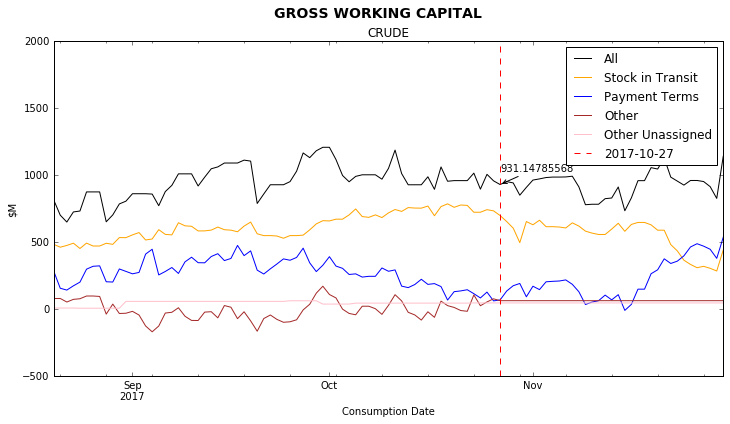

In [52]:
# group by strategies the total amount
daily_wc = df_final.groupby('Consumption Date')['WC Amount'].sum().reset_index()

# our GWC amount for the date
radar_date_wc = daily_wc.set_index('Consumption Date').loc[radar_date]['WC Amount']

# Create the figure and the axes
fig, ax = plt.subplots()

# Plot the data
daily_wc.plot(kind='line',y='WC Amount', x='Consumption Date', ax=ax, figsize=(12, 6), color= 'black', label='All')
df_transit.plot(kind='line', y='WC Amount', x='Consumption Date',ax=ax, figsize=(12,6), color='orange', label= 'Stock in Transit')
df_terms.plot(kind='line', y='WC Amount', x='Consumption Date',ax=ax, figsize=(12,6), color='blue', label='Payment Terms')
df_plot_others.plot(kind='line', y='WC Amount', x='Consumption Date',ax=ax, figsize=(12,6), color='brown', label='Other')
df_plot_others_u.plot(kind='line', y='WC Amount', x='Consumption Date',ax=ax, figsize=(12,6), color='pink',
                      label='Other Unassigned')

# Set limits and labels
ax.set_xlim(['2017-08-20', end_date])
ax.set(title=radar_report, xlabel='Consumption Date', ylabel='$M')

# Add a line for radar date
ax.axvline(x=radar_date, color='r',
           label=radar_date,
           linestyle='--',
           linewidth=1)

ax.annotate(radar_date_wc,
            xy=(radar_date, radar_date_wc), xycoords='data',
           xytext=(radar_date, radar_date_wc + 100), textcoords='data',
           arrowprops=dict(arrowstyle="->",
                          connectionstyle="arc3")
            )

# Hide the legend
ax.legend().set_visible(True)

# Title the figure
fig.suptitle('GROSS WORKING CAPITAL', fontsize=14, fontweight='bold');

## Others

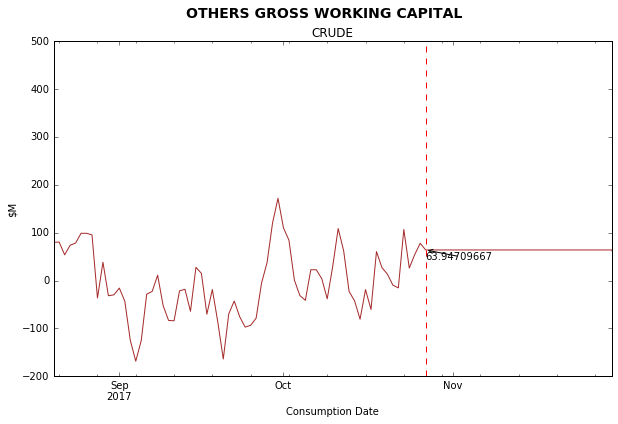

In [53]:
# we are only interested in others so we filter the final df
df_final_others = df_final[df_final['Consumption Type'] == 'Other']

#group by day
daily_wc_others = df_final_others.groupby('Consumption Date')['WC Amount'].sum().reset_index()

# value of others in radar date
radar_date_wc_other = daily_wc_others.set_index('Consumption Date').loc[radar_date]['WC Amount']

# Create the figure and the axes
fig, ax = plt.subplots()

# Plot the data
daily_wc_others.plot(kind='line',y='WC Amount', x='Consumption Date', ax=ax, figsize=(10, 6), color = 'brown')

# Set limits and labels
ax.set_xlim(['2017-08-20', end_date])
ax.set(title=radar_report, xlabel='Consumption Date', ylabel='$M')

# Add a line for radar date
ax.axvline(x=radar_date, color='r',
           label=radar_date,
           linestyle='--',
           linewidth=1)

ax.annotate(radar_date_wc_other,
            xy=(radar_date, radar_date_wc_other), xycoords='data',
           xytext=(radar_date, radar_date_wc_other - 20), textcoords='data',
           arrowprops=dict(arrowstyle="->",
                          connectionstyle="arc3")
            )

# Hide the legend
ax.legend().set_visible(False)

# Title the figure
fig.suptitle('OTHERS GROSS WORKING CAPITAL', fontsize=14, fontweight='bold');

# Export 2 - After Adjustments

In [38]:
# before macros
#writer = pd.ExcelWriter('before macros.xlsx')
#df.to_excel(writer, 'data')
#writer.save()

In [39]:
# stock in transit
#writer = pd.ExcelWriter('stock_in_transit.xlsx')
#stock_in_transit.to_excel(writer, 'data')
#writer.save()

In [40]:
# payment terms
#writer = pd.ExcelWriter('payment_terms.xlsx')
#payment_terms.to_excel(writer, 'data')
#writer.save()

In [41]:
# tableau data
#writer = pd.ExcelWriter('tableau data.xlsx')
#df_output.to_excel(writer, 'Tableau')
#writer.save()

In [42]:
# others
#writer = pd.ExcelWriter('others.xlsx')
#df_others.to_excel(writer, 'data')
#writer.save()

In [171]:
# others with description
#writer = pd.ExcelWriter('others desc.xlsx')
#df_others4.to_excel(writer, 'data')
#writer.save()

In [54]:
# final output
writer = pd.ExcelWriter('final output.xlsx')
df_final.to_excel(writer, 'data')
writer.save()

In [133]:
# test
#writer = pd.ExcelWriter('final output.xlsx')
#df_test.to_excel(writer, 'data')
#writer.save()

# Discounting Middle Distillates

In [129]:
# extract gross working capital and multiply by -1
act_gross = pd.read_excel('1ALLBOOKWCActuals - ETRM_GROSS.xlsm', sheetname='MD', header=None,
                          names = ["Company Code", "Consumption Date", "Strategy", "WC Amount"])

#selecting cols
act_gross = act_gross[['Consumption Date', 'Strategy', 'WC Amount']]
act_gross['WC Amount'] = act_gross['WC Amount']/1000000
act_gross['WC Amount'] = act_gross['WC Amount']*-1

In [130]:
# extract net working capital
act_net = pd.read_excel('1ALLBOOKWCActuals - ETRM_NET.xlsm', sheetname='MD', header=None,
                          names = ["Company Code", "Consumption Date", "Strategy", "WC Amount"])

#selecting cols
act_net = act_net[['Consumption Date', 'Strategy', 'WC Amount']]
act_net['WC Amount'] = act_net['WC Amount']/1000000

In [308]:
# joining gross and net

df_discounting = pd.concat([act_gross, act_net])
df_discounting.shape

(1229475, 3)

In [309]:
# groupby and exclude the small amounts

df_discounting = df_discounting.groupby(['Consumption Date', 'Strategy']).sum().reset_index()
df_discounting = df_discounting[(df_discounting['WC Amount'] > 0.1) | (df_discounting['WC Amount'] < -0.1) ]
df_discounting = df_discounting.reset_index(drop=True)
df_discounting.shape

(18756, 3)

In [310]:
# only the radar date and defining days_count

df_discounting_radar_date = df_discounting[(df_discounting['Consumption Date'] == radar_date)]
df_discounting_radar_date = df_discounting_radar_date.reset_index(drop=True)
disc_days_count = df_discounting_radar_date.shape[0]

In [311]:
# replicating the data until the last day of radar report

df_discounting_replication = pd.concat([df_discounting_radar_date]*add_days)
df_discounting_replication = df_discounting_replication.reset_index(drop=True)

In [312]:
# changing the dates: from radar date + 1 day until last day of next month

for x in xrange(0,add_days):
    df_discounting_replication.iloc[x*disc_days_count:disc_days_count*(x+1)]['Consumption Date'] = \
    df_discounting_replication.iloc[x*disc_days_count:disc_days_count*(x+1)]['Consumption Date'] + pd.to_timedelta(x+1,'D')

In [313]:
df_discounting = pd.concat([df_discounting, df_discounting_replication])

In [314]:
df_discounting['Consumption Type'] = 'Discounting'
df_discounting = df_discounting.reset_index(drop=True)

In [315]:
# this gives all strategies available in the analytical report
output_strategy = df_output[['Strategy', 'Strategy name', 'Global Book name', 'Line of Business','Book Name', 'Portfolio name' ]]
output_strategy = output_strategy.drop_duplicates()
output_strategy = output_strategy.reset_index(drop=True)

In [316]:
# this gives all strategies from ETRM (file needs to be updated before running the script)
all_strategies = pd.read_excel('all_strategy.xlsx')
all_strategies = all_strategies[['Strategy', 'Strategy name','Global Book name', 'Line of Business','Book Name', 'Portfolio name' ]]
all_strategies['Portfolio name update'] = all_strategies['Line of Business'].str[:3] + ' ' + all_strategies['Portfolio name']
all_strategies['Portfolio name'] = all_strategies['Portfolio name update']
all_strategies = all_strategies[['Strategy', 'Strategy name','Global Book name', 'Line of Business','Book Name', 'Portfolio name' ]]

In [317]:
df_discounting = df_discounting.merge(output_strategy, on='Strategy', how='left')

In [318]:
df_discounting2 = all_strategies[['Strategy', 'Strategy name']]

In [319]:
df_discounting3 = df_discounting.merge(all_strategies, on='Strategy',how='left')

In [320]:
df_discounting3['Strategy name'] = np.where(df_discounting3['Strategy name_x'].isnull() == True,
                                          df_discounting3['Strategy name_y'], df_discounting3['Strategy name_x'])

df_discounting3['Global Book name'] = np.where(df_discounting3['Global Book name_x'].isnull() == True,
                                          df_discounting3['Global Book name_y'], df_discounting3['Global Book name_x'])

df_discounting3['Line of Business'] = np.where(df_discounting3['Line of Business_x'].isnull() == True,
                                          df_discounting3['Line of Business_y'], df_discounting3['Line of Business_x'])

df_discounting3['Book Name'] = np.where(df_discounting3['Book Name_x'].isnull() == True,
                                          df_discounting3['Book Name_y'], df_discounting3['Book Name_x'])

df_discounting3['Portfolio name'] = np.where(df_discounting3['Portfolio name_x'].isnull() == True,
                                          df_discounting3['Portfolio name_y'], df_discounting3['Portfolio name_x'])

In [321]:
# convert strategy to string
df_discounting3['Strategy'] = df_discounting3['Strategy'].astype(str)

In [322]:
# adding company name and updating portfolio name
df_discounting3 = df_discounting3.fillna('Unknown')
df_discounting3['Company Name'] = np.where(df_discounting3['Line of Business'] == 'Unknown', df_discounting3['Strategy'].str[:3], 
                                    df_discounting3['Line of Business'].str[:3])
df_discounting3['Portfolio name'] = np.where(df_discounting3['Portfolio name'] == 'Unknown', df_discounting3['Strategy'], df_discounting3['Portfolio name'])

In [323]:
#selecting the cols

df_discounting_final = df_discounting3[['Consumption Date', 'Strategy','WC Amount', 'Consumption Type', 'Strategy name','Company Name',
                    'Global Book name','Line of Business','Book Name', 'Portfolio name']]

In [324]:
# align columns to final output

result_discounting = pd.DataFrame(columns=cols)
result_discounting['Consumption Date'] = df_discounting_final['Consumption Date']
result_discounting['Consumption Type'] = df_discounting_final['Consumption Type']
result_discounting['WC Amount'] = df_discounting_final['WC Amount']
result_discounting['Strategy'] = df_discounting_final['Strategy']
result_discounting['Strategy name'] = df_discounting_final['Strategy name']
result_discounting['Company Name'] = df_discounting_final['Company Name']
result_discounting['Global Book name'] = df_discounting_final['Global Book name']
result_discounting['Line of Business'] = df_discounting_final['Line of Business']
result_discounting['Book Name'] = df_discounting_final['Book Name']
result_discounting['Portfolio name'] = df_discounting_final['Portfolio name']

# export discounting

In [325]:
# discounting
writer = pd.ExcelWriter('discounting.xlsx')
result_discounting.to_excel(writer, 'data')
writer.save()